# ResNet 기반 Eurosat 분류(10 classes)

**데이터셋 살펴보기 (info)**

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

class_names = info.features["label"].names
# ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses’]

n_classes = info.features["label"].num_classes # 5

dataset_size = info.splits["train"].num_examples # 3670


In [ ]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

## Eurosat 다운로드

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras import layers

train_set_raw, test_set_raw, valid_set_raw = tfds.load("eurosat", as_supervised=True, split=["train[:75%]", "train[75%:90%]", "train[90%:]"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteSK3U23/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


## 이미지 전처리

In [2]:
# Processing
def preprocess(image, label):
  resized_image = tf.image.resize(image, [64, 64])
  # ResNet 입력 사이즈로 변경
  # final_image = keras.applications.resnet50.preprocess_input(resized_image)
  return resized_image, label

batch_size = 32

# Repeat이 무한 반복된다.
train_set = train_set_raw.shuffle(1000).repeat()
valid_set = valid_set_raw.shuffle(1000).repeat()

# GPU 사전 준비
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

**저장된 이미지 Shape 확인**

Target: tf.Tensor(0, shape=(), dtype=int64)


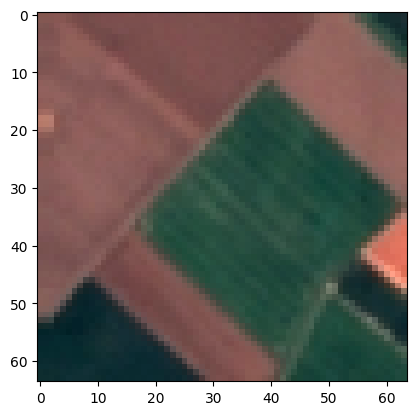

In [15]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img


for data_batch, labels_batch in train_set:
    plt.imshow(array_to_img(data_batch[0]))
    print("Target:", labels_batch[0])   # 위성 사진 분류 10 Class
    break

## Fine_Tuning 미적용

In [3]:
# Data Augmentation
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2),
    ]
)

In [4]:
# ResNet50 사용
base_model =  keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False)
base_model.trainable = False

input = keras.Input(shape = (64, 64, 3))
x = data_augmentation(input)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x)

avg = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(10, activation="softmax")(avg)

model = keras.models.Model(inputs=input, outputs=output)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 64, 64, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 64, 64, 3)        0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

**모델 학습**

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Callbacks - CheckPoint
callbacks = [
    # earlystopping
    keras.callbacks.EarlyStopping(
        monitor = "val_accuracy",
        patience = 4
    ),

    # checkpoint
    keras.callbacks.ModelCheckpoint(
        filepath = "data_augmentation.keras",
        save_best_only = True,
        monitor = "val_loss"
    )
]

history = model.fit(train_set,
                    epochs=20,
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * 27000 / batch_size),
                    validation_steps=int(0.15 * 27000 / batch_size),
                    callbacks = callbacks)

**그래프**

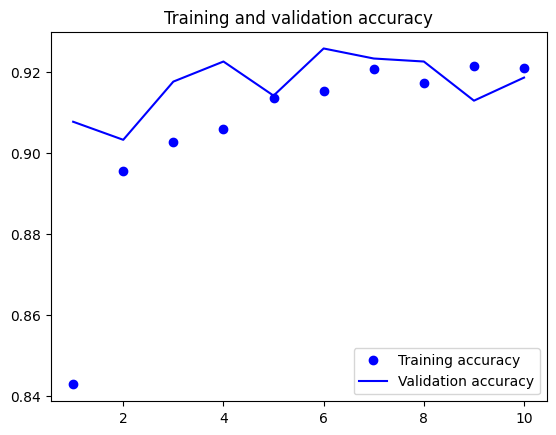

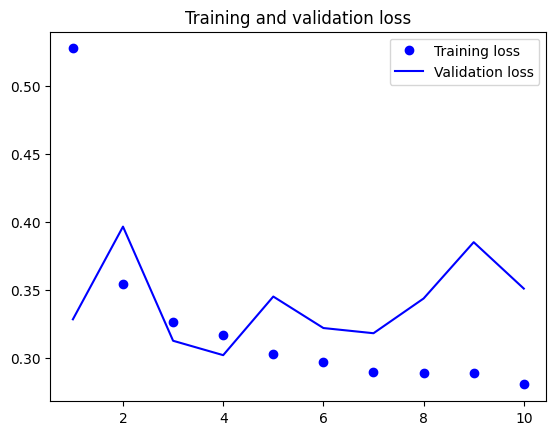

In [ ]:
import matplotlib.pyplot as plt

# 학습 그래프
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

**성능 측정**

In [ ]:
# Checkpoint 불러오기
test_model = keras.models.load_model("data_augmentation.keras")

# 평가
test_loss, test_acc = test_model.evaluate(test_set)
print(f"손실:{test_loss:.3f}")
print(f"정확도:{test_acc:.3f}")


127/127 [==============================] - 4s 20ms/step - loss: 0.3922 - accuracy: 0.8847
손실:0.392
정확도:0.885


## Fine_Tuning 적용

**ConvNet - ResNet 사용 (4계층 학습)**

In [6]:
base_model= tf.keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False)
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [7]:
# Fine_tuning
for layer in base_model.layers[-4:]:
  layer.trainable = True

# BatchNormalization Layer 제외
base_model.layers[-3].trainable = False

**모델 생성**

In [8]:
input = keras.Input(shape = (64, 64, 3))
x = data_augmentation(input)
x = keras.applications.resnet50.preprocess_input(x)
x = base_model(x)

avg = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(10, activation="softmax")(avg)

model = keras.models.Model(inputs=input, outputs=output)

**모델 학습**

In [9]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Callbacks - CheckPoint
callbacks = [
    # earlystopping
    keras.callbacks.EarlyStopping(
        monitor = "val_accuracy",
        patience = 4
    ),

    # checkpoint
    keras.callbacks.ModelCheckpoint(
        filepath = "fine_tuning.keras",
        save_best_only = True,
        monitor = "val_loss"
    )
]

history = model.fit(train_set,
                    epochs=20,
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * 27000 / batch_size),
                    validation_steps=int(0.15 * 27000 / batch_size),
                    callbacks = callbacks)

Epoch 1/20
632/632 [==============================] - 77s 63ms/step - loss: 0.8353 - accuracy: 0.7612 - val_loss: 0.8782 - val_accuracy: 0.7688
Epoch 2/20
632/632 [==============================] - 38s 61ms/step - loss: 0.4339 - accuracy: 0.8624 - val_loss: 1.1364 - val_accuracy: 0.7207
Epoch 3/20
632/632 [==============================] - 38s 60ms/step - loss: 0.3475 - accuracy: 0.8856 - val_loss: 1.0690 - val_accuracy: 0.7646
Epoch 4/20
632/632 [==============================] - 44s 69ms/step - loss: 0.3002 - accuracy: 0.9008 - val_loss: 0.4700 - val_accuracy: 0.8661
Epoch 5/20
632/632 [==============================] - 41s 65ms/step - loss: 0.2773 - accuracy: 0.9093 - val_loss: 0.4605 - val_accuracy: 0.8666
Epoch 6/20
632/632 [==============================] - 41s 65ms/step - loss: 0.2458 - accuracy: 0.9204 - val_loss: 0.2621 - val_accuracy: 0.9142
Epoch 7/20
632/632 [==============================] - 38s 60ms/step - loss: 0.2419 - accuracy: 0.9216 - val_loss: 0.3477 - val_accuracy:

**그래프**

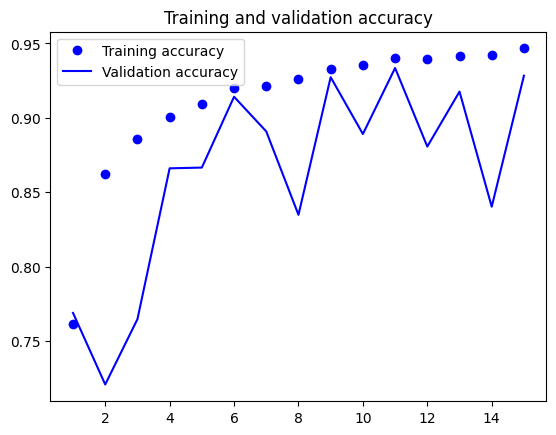

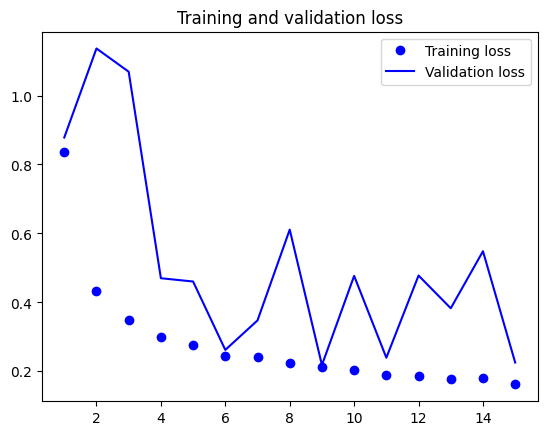

In [10]:
import matplotlib.pyplot as plt

# 학습 그래프
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

**성능 측정**

In [11]:
# Checkpoint 불러오기
test_model = keras.models.load_model("fine_tuning.keras")

# 평가
test_loss, test_acc = test_model.evaluate(test_set)
print(f"손실:{test_loss:.3f}")
print(f"정확도:{test_acc:.3f}")


127/127 [==============================] - 4s 20ms/step - loss: 0.2526 - accuracy: 0.9207
손실:0.253
정확도:0.921


## 새로운 이미지 예측

정답 Class:: tf.Tensor(4, shape=(), dtype=int64)
1/1 [==============================] - 0s 25ms/step
예측 Class: 4


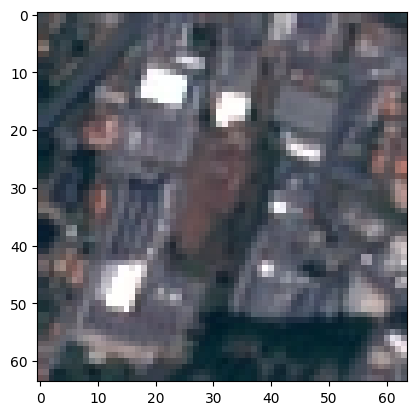

In [13]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img


for data_batch, labels_batch in test_set:
    plt.imshow(array_to_img(data_batch[0]))
    print("정답 Class::", labels_batch[0])   # 위성 사진 분류 10 Class

    prediction = test_model.predict(data_batch)
    print("예측 Class:", prediction[0].argmax())   # 위성 사진 분류 10 Class
    break